# Traditional Machine Learning Classifiers
Iterating through classifiers in the scikit-learn toolbox.

## Prepare environment

In [ ]:
pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import modules

In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils import shuffle
import sklearn.feature_selection
from sklearn import metrics
import gc
import os
import sys

### Unzip data

In [ ]:
if 'google.colab' in sys.modules:
  !unzip /content/drive/MyDrive/DL\ Model\ Data/Upload.zip
else:
  %cd C:\\Users\\jdivers\\Desktop\\ML_Model_Data

C:\Users\jdivers\Desktop\ML_Model_Data


## Prepare dataset

### Define Dataset class

In [ ]:
# Define dataset
class UMSCCDataset():
  def __init__(self, root, order, transform = None, augment = False):
    self.root = root
    self.transform = transform
    self.augment = augment
    self.order = order
    if self.order == ['all']:
      self.order = ['NADH', 'FAD', 'G', 'S', 'ORR', 'Photons', 'Tau1', 'Tau2', 'Alpha Ratio']
    self.stackheight = len(self.order)

    images = []
    labels = []
    self.samples = []
    self.modality = []

    ##############################
    ## Get metadata for samples ##
    ##############################
    if not self.augment:
      for animal in os.listdir(self.root):
        for sample in os.listdir(self.root + os.sep + animal):
          for fov in os.listdir(self.root + os.sep + animal + os.sep + sample):
            # Get target
            route = self.root + os.sep + animal + os.sep + sample + os.sep + fov
            self.samples.append(route)
            if animal[0] == ('x' or 'X'):
              d = 0
            else:
              d = 1
            labels.append(d)

            ########################
            ## Stack input images ##
            ########################
            x = np.zeros((self.stackheight, 512, 512), dtype= np.float32)

            # Parse input order into readable modalities
            mode = []
            for name in self.order:
              if 'NADH' == name or 'nadh' == name: mode.append('nadh.tiff')
              elif 'FAD' == name or 'fad' == name: mode.append('fad.tiff')
              elif 'G' == name or 'g' == name: mode.append('G.tiff')
              elif 'S' == name or 's' == name: mode.append('S.tiff')
              elif 'orr' == name or 'ORR' == name: mode.append('orr.tiff')
              elif 'photons' == name or 'Photons' == name or 'int' == name: mode.append('photons.tiff')
              elif 'tau1' == name or 'Tau1' == name or 't1' == name or 'T1' == name: mode.append('t1.tiff')
              elif 'tau2' == name or 'Tau2' == name or 't2' == name or 'T2' == name: mode.append('t2.tiff')
              elif 'alpha ratio' == name or 'a ratio' == name or 'Alpha Ratio' == name or 'a1a2' == name or 'A1A2' == name or 'A1A2 ratio' == name: mode.append(['a1.tiff', 'a2.tiff'])
              else: assert('Unrecognized modality input in order variable')

            # Load stack
            for ii, tiff in enumerate(mode):
              if type(tiff) is list:
                layer1 = np.array(Image.open(route + os.sep + tiff[0]), dtype = np.float32)
                layer2 = np.array(Image.open(route + os.sep + tiff[1]), dtype = np.float32)
                mask =  (np.array(layer2) <= 0) | (np.array(layer1) < 0)
                layer2[mask] = 1
                layer1[mask] = 0
                layer = np.divide(layer1, layer2)
              else:
                layer = np.array(Image.open(route + os.sep + tiff), dtype=np.float32)
              x[ii, :, :] = layer
            images.append(x)

            self.modality = mode

      #################################
      ## Augment data set by tencrop ##
      #################################
    else:
      cropper = transforms.FiveCrop(256)
      for animal in os.listdir(self.root):
        for sample in os.listdir(self.root + os.sep + animal):
          for fov in os.listdir(self.root + os.sep + animal + os.sep + sample):
            # Get target
            route = self.root + os.sep + animal + os.sep + sample + os.sep + fov
            self.samples.append(sample)
            if animal[0] == ('x' or 'X'):
              d = 0
            else:
              d = 1
            labels.extend(5*[d]) # Duplicate labels for augmented data

            ########################
            ## Stack input images ##
            ########################
            x = np.zeros((self.stackheight, 256, 256, 5), dtype= np.float32)

            mode = self.stackheight*[None]
            # Parse input order into readable modalities
            mode = []
            for name in self.order:
              if 'NADH' == name or 'nadh' == name: mode.append('nadh.tiff')
              elif 'FAD' == name or 'fad' == name: mode.append('fad.tiff')
              elif 'G' == name or 'g' == name: mode.append('G.tiff')
              elif 'S' == name or 's' == name: mode.append('S.tiff')
              elif 'orr' == name or 'ORR' == name: mode.append('orr.tiff')
              elif 'photons' == name or 'Photons' == name or 'int' == name: mode.append('photons.tiff')
              elif 'tau1' == name or 'Tau1' == name or 't1' == name or 'T1' == name: mode.append('t1.tiff')
              elif 'tau2' == name or 'Tau2' == name or 't2' == name or 'T2' == name: mode.append('t2.tiff')
              elif 'alpha ratio' == name or 'a ratio' == name or 'Alpha Ratio' == name or 'a1a2' == name or 'A1A2' == name or 'A1A2 ratio' == name: mode.append(['a1.tiff', 'a2.tiff'])
              else: assert('Unrecognized modality input in order variable')

            # Load stack
            for ii, tiff in enumerate(mode):
              if type(tiff) is list:
                layer1 = cropper(Image.open(route + os.sep + tiff[0]))
                layer2 = cropper(Image.open(route + os.sep + tiff[1]))
                for jj in range(5):
                  top = np.array(layer1[jj], dtype=np.float32)
                  bottom = np.array(layer2[jj], dtype=np.float32)
                  mask =  (top < 0) | (bottom <= 0)
                  top[mask] = 0
                  bottom[mask] = 1
                  out = np.divide(top, bottom)
                  x[ii, :, :, jj] = np.array(out, dtype=np.float32)
              else:
                layer = cropper(Image.open(route + os.sep + tiff))
                for jj in range(5):
                  x[ii, :, :, jj] = np.asarray(layer[jj], dtype=np.float32)
            for kk in range(5):
              images.append(x[:,:,:,kk])

            self.modality.extend(5*[mode])

      # Convert and scale down by 8-bit and remove negatives
      images = np.array(images)
      images = images/255
      images[images<0] = 0

      self.images = images
      self.labels = np.array(labels, dtype=np.float32)
      self.dataset_size = len(self.images)

  def __len__(self):
    return self.dataset_size

  def __getitem__(self, index):
    img = torch.from_numpy(self.images[index])
    lab = self.labels[index]
    return img, lab

  def show_random(self):
    transform = transforms.Compose([transforms.ToPILImage()])
    f, ax = plt.subplots(5, len(self.order), figsize=(7, 7))
    for ii in range(5):
      index = np.random.randint(0, len(self))
      for jj in range(len(self.order)):
        ax[ii, jj].imshow(transform(self.images[index, jj, :, :]*255))
        ax[ii, jj].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        ax[ii, jj].set_title(f'Label: {self.labels[index]}. Mode: {self.order[jj]}', fontsize=10)
    plt.show()

  def norm_to_max(self):
    self.images = self.images/np.max(self.images)

### Transform
...image data to chain of histogram distributions

In [ ]:
class DistData():
  def __init__(self, image_data, bins=25):
    self.im_dim = np.shape(image_data)[2:4]
    self.channels = np.shape(image_data)[1]

# Chain together histograms for each modality
    dist_data = np.empty((np.shape(image_data)[0], self.channels*bins))
    for idx, img in enumerate(image_data):
      hc = np.array([])
      for channel in img:
        h, _ = np.histogram(channel, bins=bins)
        hc = np.append(hc, h)
      dist_data[idx] = hc
    self.dists = dist_data

  def __len__(self):
    return np.shape(self.dists)[0]

  def normalize(self):
    self.dists = self.dists/np.prod(self.im_dim)

## Permuting models and datasets to determine optimum

### Define Models for all

In [ ]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

### Comparing performance on individual groups

#### Create datasets for all pairs

In [ ]:
# Load data for all modes for each pairing
modes = ['all']
times = ['0hpt-Baseline', '1hpt', '24hpt', '48hpt']
treatment = ['NT', 'XT']
sen_img_set, res_img_set, sen_dist_set, res_dist_set = {}, {}, {}, {},
keys =[]
bins = 25

for tx in treatment:
  for t in times:
    key = (tx + '_' + t)
    dir_ext = os.sep + tx + os.sep + t
    try:
      sen_img_set[key] = UMSCCDataset('Stacks' + os.sep + '22B' + dir_ext, modes, augment = True)
      res_img_set[key] = UMSCCDataset('Stacks' + os.sep + '47' + dir_ext, modes, augment = True)
      sen_dist_set[key] = DistData(sen_img_set[key].images, bins=bins)
      res_dist_set[key] = DistData(res_img_set[key].images, bins=bins)
      sen_dist_set[key].normalize()
      res_dist_set[key].normalize()
      keys.append(key)
    except Exception as e:
      print(f'Skipping {key}: {e}')

modes = sen_img_set[key].order

Skipping XT_0hpt-Baseline: [WinError 3] The system cannot find the path specified: 'Stacks\\22B\\XT\\0hpt-Baseline'
Skipping XT_48hpt: cannot identify image file 'Stacks\\47\\XT\\48hpt\\y120\\sample3\\fov3\\nadh.tiff'


#### Visualize input data
Random sample from random pair

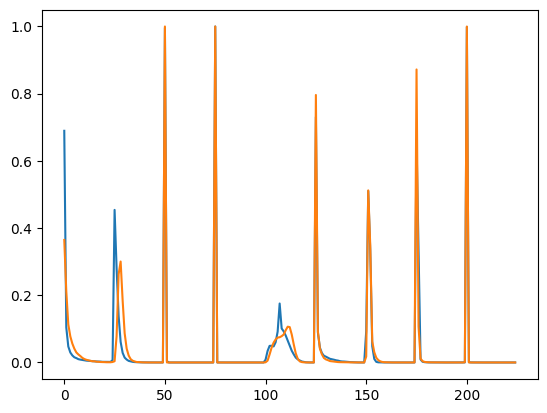

In [ ]:
rand_key = np.random.choice(list(sen_dist_set.keys()))
idx = np.random.randint(0, len(sen_dist_set))
p = plt.plot(sen_dist_set[rand_key].dists[idx])
idx = np.random.randint(0, len(res_dist_set))
p = plt.plot(res_dist_set[rand_key].dists[idx])

#### Check dataset sizes

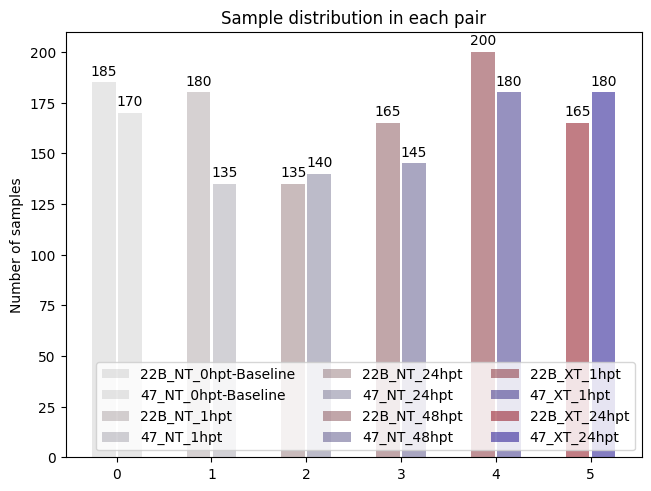

In [ ]:
fig, ax = plt.subplots(layout='constrained')
x = np.arange(2)
w = 0.25
m = 0
l = {}
r,g,b,t = 4*[0.1]
n = 0

for key in keys:
  offset = w*m
  p = ax.bar((m-0.55*w, m+0.55*w), (len(sen_dist_set[key]), len(res_dist_set[key])), w,
             label=('22B_' + key, '47_' + key), color = [(r+n, g+0.1*n, b+0.2*n, t+n), (b+0.2*n, g+0.1*n, r+n, t+n)])
  ax.bar_label(p, padding=3)
  m += 1
  n += 0.1

ax.set_ylabel('Number of samples')
ax.set_title('Sample distribution in each pair')
leg = ax.legend(loc='lower right', ncols=3)


#### Model testing
Iterating through all models listed (from scikit learn module)

In [ ]:
results = {}
for key in keys:
  # Define sensitive and resistant data sets for pair
  X_sen = sen_dist_set[key].dists
  y_sen = sen_img_set[key].labels
  X_res = res_dist_set[key].dists
  y_res = res_img_set[key].labels

  # Combine and shuffle
  X = np.concatenate((X_sen, X_res))
  y = np.concatenate((y_sen, y_res))
  X, y = shuffle(X, y)

  # Randomly split into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.4, random_state=42
  )

  # Fit each model and test
  score = {}
  for name, clf in zip(names, classifiers):
      pipe = make_pipeline(StandardScaler(), clf)
      pipe.fit(X_train, y_train)
      score[name] = pipe.score(X_test, y_test)
      gc.collect()
  results[key] = score

C:\Users\jdivers\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\jdivers\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\jdivers\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\jdivers\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\jdivers\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the spec

#### Results

##### All Results

In [ ]:
# Show all results
best = {}
for key in keys:
  print()
  print(f'Scores for {key}:')
  best[key] = np.max(list(results[key].values()))
  for name in names:
    print(f'{name}: {results[key][name]*100:.2f}%')


Scores for NT_0hpt-Baseline:
Nearest Neighbors: 86.62%
Linear SVM: 73.24%
RBF SVM: 54.23%
Gaussian Process: 85.21%
Decision Tree: 69.72%
Random Forest: 72.54%
Neural Net: 85.92%
AdaBoost: 82.39%
Naive Bayes: 61.97%
QDA: 59.15%

Scores for NT_1hpt:
Nearest Neighbors: 75.40%
Linear SVM: 79.37%
RBF SVM: 58.73%
Gaussian Process: 76.19%
Decision Tree: 80.16%
Random Forest: 75.40%
Neural Net: 81.75%
AdaBoost: 81.75%
Naive Bayes: 67.46%
QDA: 53.97%

Scores for NT_24hpt:
Nearest Neighbors: 80.91%
Linear SVM: 91.82%
RBF SVM: 45.45%
Gaussian Process: 79.09%
Decision Tree: 80.91%
Random Forest: 87.27%
Neural Net: 95.45%
AdaBoost: 93.64%
Naive Bayes: 85.45%
QDA: 60.00%

Scores for NT_48hpt:
Nearest Neighbors: 84.68%
Linear SVM: 90.32%
RBF SVM: 57.26%
Gaussian Process: 81.45%
Decision Tree: 83.06%
Random Forest: 80.65%
Neural Net: 90.32%
AdaBoost: 95.16%
Naive Bayes: 79.84%
QDA: 58.87%

Scores for XT_1hpt:
Nearest Neighbors: 81.58%
Linear SVM: 82.89%
RBF SVM: 42.76%
Gaussian Process: 57.24%
Decisi

##### Summary Results

In [ ]:
# Pair-wise Best
print('Best performer for each time point:')

for key in keys:
  print(f"{key}   {list(results[key].keys())[list(results[key].values()).index(best[key])]}   {best[key]*100:.2f}%")

Best performer for each time point:
NT_0hpt-Baseline   Nearest Neighbors   86.62%
NT_1hpt   Neural Net   81.75%
NT_24hpt   Neural Net   95.45%
NT_48hpt   AdaBoost   95.16%
XT_1hpt   Neural Net   86.18%
XT_24hpt   AdaBoost   82.61%


In [ ]:
# Classifier-average Results
print('Classifier averages:')
for name in names:
  tot = 0
  for key in keys:
    tot += results[key][name]
  print(f'{name} average: {tot*100/len(keys):.2f}%')

Classifier averages:
Nearest Neighbors average: 81.36%
Linear SVM average: 81.80%
RBF SVM average: 51.41%
Gaussian Process average: 75.88%
Decision Tree average: 77.02%
Random Forest average: 75.73%
Neural Net average: 86.68%
AdaBoost average: 86.52%
Naive Bayes average: 71.38%
QDA average: 57.32%


### Combined Dataset performance testing

#### All control groups dataset

##### Get dataset

In [ ]:
# All NT groups
times = ['0hpt-Baseline', '1hpt', '24hpt', '48hpt']
treatment = ['NT']
sen_img_set, res_img_set, sen_dist_set, res_dist_set = {}, {}, {}, {},
keys =[]

for tx in treatment:
  for t in times:
    key = (tx + '_' + t)
    dir_ext = os.sep + tx + os.sep + t
    try:
      sen_img_set[key] = UMSCCDataset('Stacks/22B' + dir_ext, modes, augment = True)
      res_img_set[key] = UMSCCDataset('Stacks/47' + dir_ext, modes, augment = True)
      sen_dist_set[key] = DistData(sen_img_set[key].images, bins=25)
      res_dist_set[key] = DistData(res_img_set[key].images, bins=25)
      sen_dist_set[key].normalize()
      res_dist_set[key].normalize()
      keys.append(key)
    except Exception as e:
      print(f'Skipping {key}: {e}')

X = np.array([]).reshape(0, np.shape(sen_dist_set[key].dists)[1])
y = np.array([])
for key in keys:
  # Define sensitive and resistant data sets for pair
  X_sen = sen_dist_set[key].dists
  y_sen = sen_img_set[key].labels
  X_res = res_dist_set[key].dists
  y_res = res_img_set[key].labels


  # Combine
  X = np.concatenate((X, X_sen, X_res))
  y = np.concatenate((y, y_sen, y_res))

# Shuffle final dataset and split
X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

##### Check group sizes

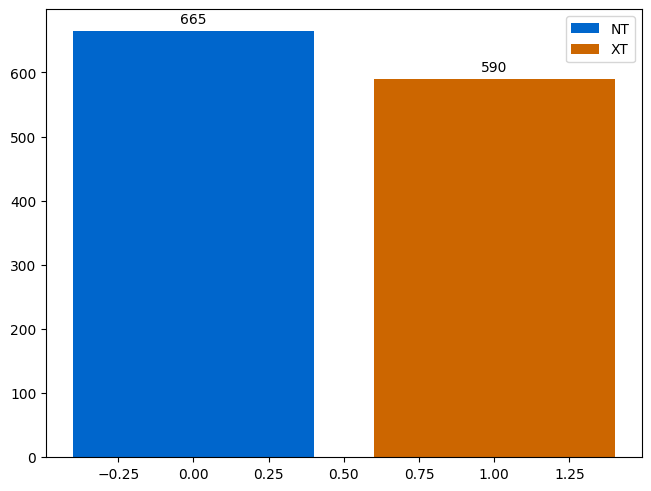

In [ ]:
fig, ax = plt.subplots(layout='constrained')
p = ax.bar((0, 1), (sum(y==0), sum(y==1)), label=('NT', 'XT'), color=[(0.0, 0.4, 0.8), (0.8, 0.4, 0.0)])
ax.bar_label(p, padding=3)
leg = ax.legend()

##### Model testing

In [ ]:
# Fit each model and test
score = {}
for name, clf in zip(names, classifiers):
    pipe = make_pipeline(StandardScaler(), clf)
    pipe.fit(X_train, y_train)
    score[name] = pipe.score(X_test, y_test)
    gc.collect()

C:\Users\jdivers\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


##### Results for all control groups combined

In [ ]:
# Show all results
best = {}
for name in names:
  print(f'{name}: {score[name]*100:.2f}%')

Nearest Neighbors: 77.09%
Linear SVM: 71.51%
RBF SVM: 52.79%
Gaussian Process: 82.67%
Decision Tree: 75.90%
Random Forest: 76.10%
Neural Net: 83.67%
AdaBoost: 79.88%
Naive Bayes: 66.93%
QDA: 69.32%


#### All radiation groups

##### Get dataset

In [ ]:
# All XT groups
times = ['1hpt', '24hpt', '48hpt']
treatment = ['XT']
sen_img_set, res_img_set, sen_dist_set, res_dist_set = {}, {}, {}, {},
keys =[]

for tx in treatment:
  for t in times:
    key = (tx + '_' + t)
    dir_ext = os.sep + tx + os.sep + t
    try:
      sen_img_set[key] = UMSCCDataset('Stacks/22B' + dir_ext, modes, augment = True)
      res_img_set[key] = UMSCCDataset('Stacks/47' + dir_ext, modes, augment = True)
      sen_dist_set[key] = DistData(sen_img_set[key].images, bins=25)
      res_dist_set[key] = DistData(res_img_set[key].images, bins=25)
      sen_dist_set[key].normalize()
      res_dist_set[key].normalize()
      keys.append(key)
    except Exception as e:
      print(f'Skipping {key}: {e}')

X = np.array([]).reshape(0, np.shape(sen_dist_set[key].dists)[1])
y = np.array([])
for key in keys:
  # Define sensitive and resistant data sets for pair
  X_sen = sen_dist_set[key].dists
  y_sen = sen_img_set[key].labels
  X_res = res_dist_set[key].dists
  y_res = res_img_set[key].labels


  # Combine
  X = np.concatenate((X, X_sen, X_res))
  y = np.concatenate((y, y_sen, y_res))

# Shuffle final dataset and split
X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

In [ ]:
for ke, va in sen_dist_set.items():
  print(ke)

XT_1hpt
XT_24hpt


##### Check group sizes

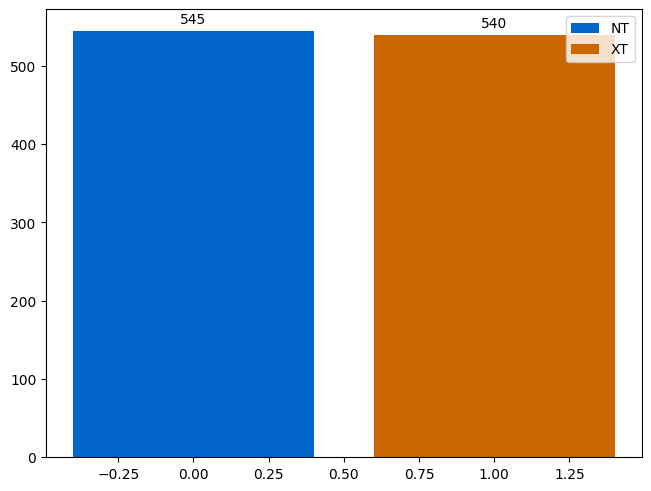

In [ ]:
fig, ax = plt.subplots(layout='constrained')
p = ax.bar((0, 1), (sum(y==0), sum(y==1)), label=('NT', 'XT'), color=[(0.0, 0.4, 0.8), (0.8, 0.4, 0.0)])
ax.bar_label(p, padding=3)
leg = ax.legend()

##### Model testing

In [ ]:
# Fit each model and test
score = {}
for name, clf in zip(names, classifiers):
    pipe = make_pipeline(StandardScaler(), clf)
    pipe.fit(X_train, y_train)
    score[name] = pipe.score(X_test, y_test)
    gc.collect()

C:\Users\jdivers\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


##### Results for all treatment groups combined

In [ ]:
# Show all results
best = {}
for name in names:
  print(f'{name}: {score[name]*100:.2f}%')

Nearest Neighbors: 73.96%
Linear SVM: 70.28%
RBF SVM: 45.85%
Gaussian Process: 79.95%
Decision Tree: 69.82%
Random Forest: 66.13%
Neural Net: 79.72%
AdaBoost: 67.28%
Naive Bayes: 54.38%
QDA: 67.74%


#### All groups dataset

##### Get dataset

In [ ]:
# All groups
times = ['0hpt-Baseline', '1hpt', '24hpt', '48hpt']
treatment = ['NT', 'XT']
sen_img_set, res_img_set, sen_dist_set, res_dist_set = {}, {}, {}, {},
keys =[]

for tx in treatment:
  for t in times:
    key = (tx + '_' + t)
    dir_ext = os.sep + tx + os.sep + t
    try:
      sen_img_set[key] = UMSCCDataset('Stacks/22B' + dir_ext, modes, augment = True)
      res_img_set[key] = UMSCCDataset('Stacks/47' + dir_ext, modes, augment = True)
      sen_dist_set[key] = DistData(sen_img_set[key].images, bins=25)
      res_dist_set[key] = DistData(res_img_set[key].images, bins=25)
      sen_dist_set[key].normalize()
      res_dist_set[key].normalize()
      keys.append(key)
    except Exception as e:
      print(f'Skipping {key}: {e}')

X = np.array([]).reshape(0, np.shape(sen_dist_set[key].dists)[1])
y = np.array([])
for key in keys:
  # Define sensitive and resistant data sets for pair
  X_sen = sen_dist_set[key].dists
  y_sen = sen_img_set[key].labels
  X_res = res_dist_set[key].dists
  y_res = res_img_set[key].labels


  # Combine
  X = np.concatenate((X, X_sen, X_res))
  y = np.concatenate((y, y_sen, y_res))

# Shuffle final dataset and split
X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

Skipping XT_0hpt-Baseline: [WinError 3] The system cannot find the path specified: 'Stacks/22B\\XT\\0hpt-Baseline'


##### Check group sizes

In [ ]:
fig, ax = plt.subplots(layout='constrained')
p = ax.bar((0, 1), (sum(y==0), sum(y==1)), label=('NT', 'XT'), color=[(0.0, 0.4, 0.8), (0.8, 0.4, 0.0)])
ax.bar_label(p, padding=3)
leg = ax.legend()

##### Model testing

In [ ]:
# Fit each model and test
score = {}
for name, clf in zip(names, classifiers):
    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    score[name] = clf.score(X_test, y_test)
    gc.collect()

##### Results for all groups combined

In [ ]:
# Show all results
best = {}
for name in names:
  print(f'{name}: {score[name]*100:.2f}%')

Nearest Neighbors: 73.96%
Linear SVM: 70.28%
RBF SVM: 45.85%
Gaussian Process: 79.95%
Decision Tree: 69.82%
Random Forest: 66.13%
Neural Net: 79.72%
AdaBoost: 67.28%
Naive Bayes: 54.38%
QDA: 67.74%


## Feature selection using XT dataset

##### Reload fresh dataset

In [ ]:
# All XT groups
times = ['1hpt', '24hpt', '48hpt']
treatment = ['XT']
sen_img_set, res_img_set, sen_dist_set, res_dist_set = {}, {}, {}, {},
keys =[]

for tx in treatment:
  for t in times:
    key = (tx + '_' + t)
    dir_ext = os.sep + tx + os.sep + t
    try:
      sen_img_set[key] = UMSCCDataset('Stacks/22B' + dir_ext, modes, augment = True)
      res_img_set[key] = UMSCCDataset('Stacks/47' + dir_ext, modes, augment = True)
      sen_dist_set[key] = DistData(sen_img_set[key].images, bins=25)
      res_dist_set[key] = DistData(res_img_set[key].images, bins=25)
      sen_dist_set[key].normalize()
      res_dist_set[key].normalize()
      keys.append(key)
    except Exception as e:
      print(f'Skipping {key}: {e}')

X = np.array([]).reshape(0, np.shape(sen_dist_set[key].dists)[1])
y = np.array([])
for key in keys:
  # Define sensitive and resistant data sets for pair
  X_sen = sen_dist_set[key].dists
  y_sen = sen_img_set[key].labels
  X_res = res_dist_set[key].dists
  y_res = res_img_set[key].labels


  # Combine
  X = np.concatenate((X, X_sen, X_res))
  y = np.concatenate((y, y_sen, y_res))

# Shuffle final dataset and split
X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

### Data before selection

Data has 225 features.


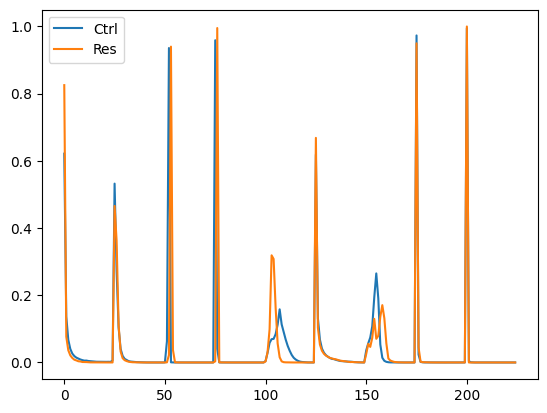

In [ ]:
# Plot one random sample from each class
idx1 = np.random.randint(0, len(X))
idx2 = np.random.randint(0, len(X))
p = plt.plot(X[idx1], label='Res' if y[idx1] == 1 else 'Ctrl')
while y[idx2] == y[idx1]:
  idx2 = np.random.randint(0, len(X))
p = plt.plot(X[idx2], label='Res' if y[idx2] == 1 else 'Ctrl')
leg = plt.legend()

print(f'Data has {np.shape(X)[1]} features.')

### Variance-based selection

In [ ]:
# Select out top ~quartile of features using naive variance
thresh = 0
X_whit = X
while np.shape(X_whit)[1] > 0.25*np.shape(X)[1]:
  sel = sklearn.feature_selection.VarianceThreshold(thresh)
  X_whit = sel.fit_transform(X)
  thresh += 0.00001
print(f'Size of whittled dataset: {np.shape(X_whit)}')
feat_names = []
for mode in modes:
  for bin in range(bins):
    feat_names.append(mode+'_' + str(bin))
fn = list(sel.get_feature_names_out(feat_names))

Size of whittled dataset: (1085, 56)


Data has 56 features.


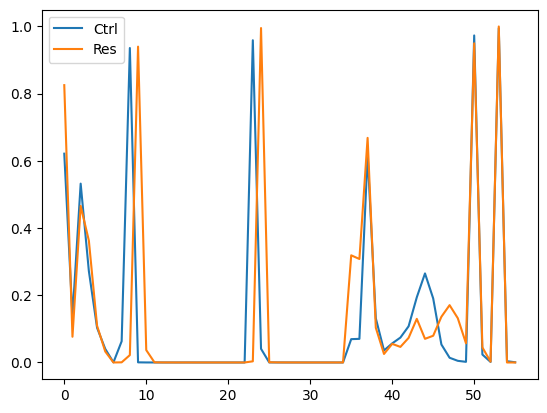

In [ ]:
# Plot the same two samples but now the whittled data
p = plt.plot(X_whit[idx1], label='Res' if y[idx1] == 1 else 'Ctrl')
p = plt.plot(X_whit[idx2], label='Res' if y[idx2] == 1 else 'Ctrl')
leg = plt.legend()

print(f'Data has {np.shape(X_whit)[1]} features.')

##### Test performance with naively selected features

In [ ]:
# Shuffle final dataset and split
X, y = shuffle(X_whit, y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Fit each model and test
score = {}
for name, clf in zip(names, classifiers):
    pipe = make_pipeline(StandardScaler(), clf)
    pipe.fit(X_train, y_train)
    score[name] = pipe.score(X_test, y_test)
    gc.collect()

C:\Users\jdivers\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
# Show all results
for name in names:
  print(f'{name}: {score[name]*100:.2f}%')

Nearest Neighbors: 63.13%
Linear SVM: 64.75%
RBF SVM: 51.15%
Gaussian Process: 59.22%
Decision Tree: 68.20%
Random Forest: 65.44%
Neural Net: 68.66%
AdaBoost: 68.43%
Naive Bayes: 61.52%
QDA: 68.66%


#### Test perfomance using top 3 hyper-features from variance-based scoring

In [ ]:
scr = []
for mode in modes:
  fnd = [mode in n for n in fn]
  scr.append(sum(bool(bul) for bul in fnd))

top_scrs = sorted(scr, reverse=True)[:3]
top3 = [s in top_scrs for s in scr]
sel_modes = [a for a,b in zip(modes, top3) if b]
print(f'Hyper-features selected from variance scoring: {sel_modes}')

Hyper-features selected from variance scoring: ['G', 'S', 'Tau1']


##### Reload dataset with only selected modes

In [ ]:
# All XT groups
times = ['1hpt', '24hpt', '48hpt']
treatment = ['XT']
sen_img_set, res_img_set, sen_dist_set, res_dist_set = {}, {}, {}, {},
keys =[]

for tx in treatment:
  for t in times:
    key = (tx + '_' + t)
    dir_ext = os.sep + tx + os.sep + t
    try:
      sen_img_set[key] = UMSCCDataset('Stacks/22B' + dir_ext, sel_modes, augment = True)
      res_img_set[key] = UMSCCDataset('Stacks/47' + dir_ext, sel_modes, augment = True)
      sen_dist_set[key] = DistData(sen_img_set[key].images, bins=25)
      res_dist_set[key] = DistData(res_img_set[key].images, bins=25)
      sen_dist_set[key].normalize()
      res_dist_set[key].normalize()
      keys.append(key)
    except Exception as e:
      print(f'Skipping {key}: {e}')

X = np.array([]).reshape(0, np.shape(sen_dist_set[key].dists)[1])
y = np.array([])
for key in keys:
  # Define sensitive and resistant data sets for pair
  X_sen = sen_dist_set[key].dists
  y_sen = sen_img_set[key].labels
  X_res = res_dist_set[key].dists
  y_res = res_img_set[key].labels


  # Combine
  X = np.concatenate((X, X_sen, X_res))
  y = np.concatenate((y, y_sen, y_res))

# Shuffle final dataset and split
X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

##### Train and test

In [ ]:
# Fit each model and test
score = {}
for name, clf in zip(names, classifiers):
    pipe = make_pipeline(StandardScaler(), clf)
    pipe.fit(X_train, y_train)
    score[name] = pipe.score(X_test, y_test)
    gc.collect()

# Show all results
best = {}
for name in names:
  print(f'{name}: {score[name]*100:.2f}%')

Nearest Neighbors: 60.14%
Linear SVM: 59.91%
RBF SVM: 50.46%
Gaussian Process: 63.59%
Decision Tree: 52.76%
Random Forest: 57.60%
Neural Net: 62.44%
AdaBoost: 63.13%
Naive Bayes: 52.53%
QDA: 51.84%


C:\Users\jdivers\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Feature importance-based selection

##### Reload fresh dataset

In [ ]:
# All XT groups
times = ['1hpt', '24hpt', '48hpt']
treatment = ['XT']
sen_img_set, res_img_set, sen_dist_set, res_dist_set = {}, {}, {}, {},
keys =[]

for tx in treatment:
  for t in times:
    key = (tx + '_' + t)
    dir_ext = os.sep + tx + os.sep + t
    try:
      sen_img_set[key] = UMSCCDataset('Stacks/22B' + dir_ext, modes, augment = True)
      res_img_set[key] = UMSCCDataset('Stacks/47' + dir_ext, modes, augment = True)
      sen_dist_set[key] = DistData(sen_img_set[key].images, bins=25)
      res_dist_set[key] = DistData(res_img_set[key].images, bins=25)
      sen_dist_set[key].normalize()
      res_dist_set[key].normalize()
      keys.append(key)
    except Exception as e:
      print(f'Skipping {key}: {e}')

X = np.array([]).reshape(0, np.shape(sen_dist_set[key].dists)[1])
y = np.array([])
for key in keys:
  # Define sensitive and resistant data sets for pair
  X_sen = sen_dist_set[key].dists
  y_sen = sen_img_set[key].labels
  X_res = res_dist_set[key].dists
  y_res = res_img_set[key].labels


  # Combine
  X = np.concatenate((X, X_sen, X_res))
  y = np.concatenate((y, y_sen, y_res))

##### Train and test

In [ ]:
# Scale data (standardization)
score = {}
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

# Shuffle final dataset and split
X_scale, y_shuff = shuffle(X_scale, y)
X_train, X_test, y_train, y_test = train_test_split(
    X_scale, y_shuff, test_size=0.4, random_state=42
)

# Fit classifiers
# MLP
clf_nn = MLPClassifier(alpha=1, max_iter=1000)
clf_nn.fit(X_train, y_train)
score["Neural Net"] = clf_nn.score(X_test, y_test)
gc.collect()

# AdaBoost
clf_ab = AdaBoostClassifier()
clf_ab.fit(X_train, y_train)
score["AdaBoost"] = clf_ab.score(X_test, y_test)
gc.collect()

0

In [ ]:
# Show all results
for key, val in score.items():
  print(f'{key}: {val*100:.2f}%')

Neural Net: 78.57%
AdaBoost: 77.88%


##### NN-Based Feature Selection
Use weight variance to determine most "active" features and back-select

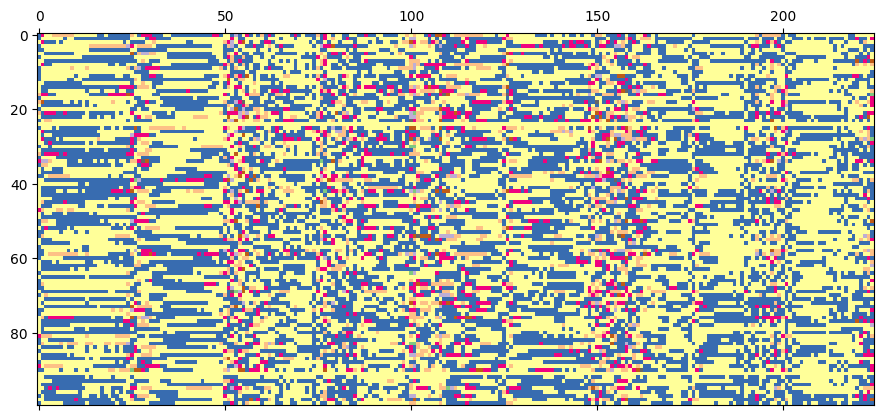

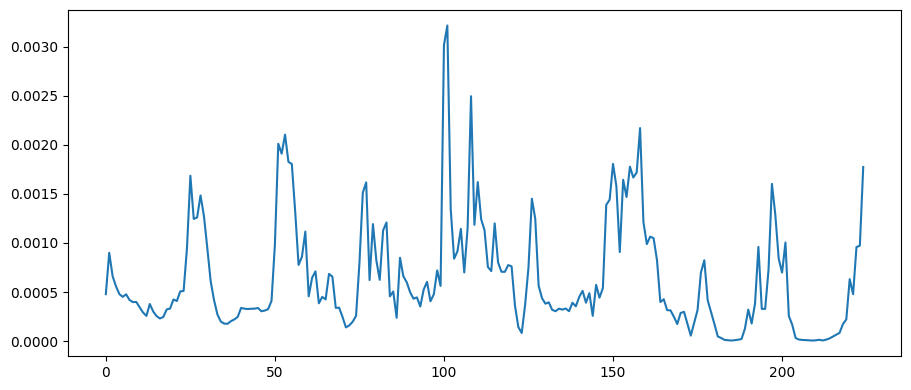

In [ ]:
weight_mat = clf_nn.coefs_[0].T
fig = plt.matshow(weight_mat, cmap=plt.cm.Accent)
plt.show()

weight_var = np.var(weight_mat, axis=0)
fig2 = plt.figure(figsize=(10.75, 4.5))
plt.plot(weight_var)
plt.show()

Select first quartile of most variable feature weights

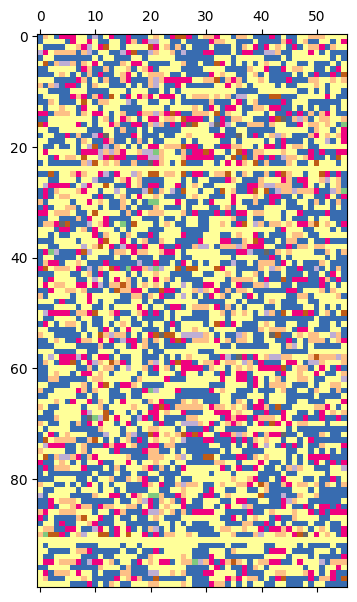

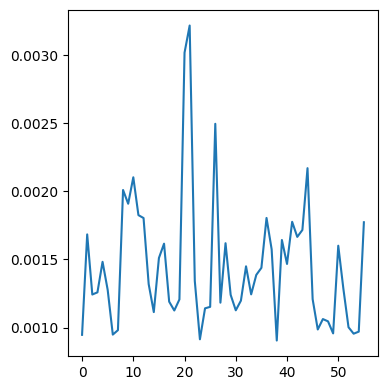

In [ ]:
top_quart = sorted(weight_var, reverse=True)[:round(.25*len(weight_var))]
selection = []
for w8 in weight_var:
  fnd = w8 in top_quart
  selection.append(fnd)
sel_weights = np.array([weight for weight, select in zip(weight_mat.T, selection) if select])

fig = plt.matshow(sel_weights.T, cmap=plt.cm.Accent)
plt.show()

sel_weight_var = np.var(sel_weights.T, axis=0)
fig2 = plt.figure(figsize=(4, 4.5))
plt.plot(sel_weight_var)
plt.show()

Use this selection to whittle down features and review

Data has 225 features.


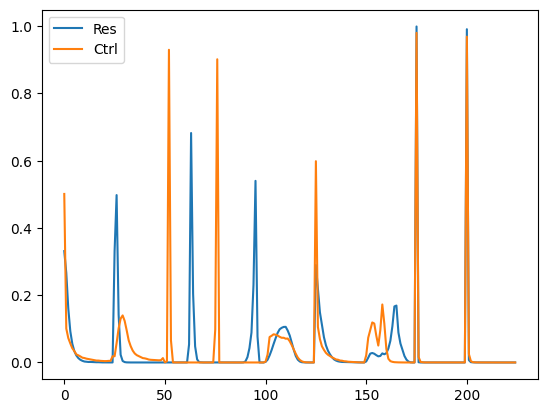

In [ ]:
# Plot one random sample from each class
idx1 = np.random.randint(0, len(X))
idx2 = np.random.randint(0, len(X))
p = plt.plot(X[idx1], label='Res' if y[idx1] == 1 else 'Ctrl')
while y[idx2] == y[idx1]:
  idx2 = np.random.randint(0, len(X))
p = plt.plot(X[idx2], label='Res' if y[idx2] == 1 else 'Ctrl')
leg = plt.legend()

print(f'Data has {np.shape(X)[1]} features.')

Data has 56 features.


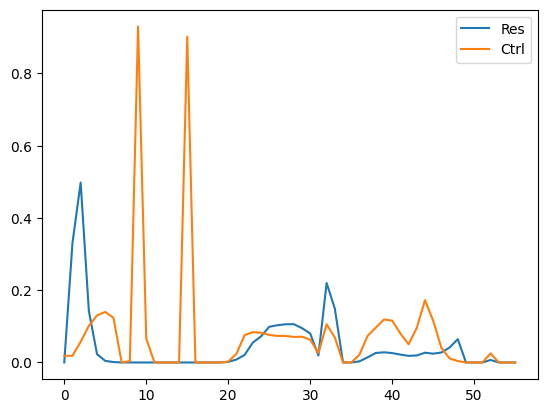

In [ ]:
X_sel = np.array([feat for feat, select in zip(X.T, selection) if select])
X_sel = X_sel.T

# Plot the same two samples but now the whittled data
p2 = plt.plot(X_sel[idx1], label='Res' if y[idx1] == 1 else 'Ctrl')
p2 = plt.plot(X_sel[idx2], label='Res' if y[idx2] == 1 else 'Ctrl')
leg = plt.legend()

print(f'Data has {np.shape(X_sel)[1]} features.')

In [ ]:
# Scale data (standardization)
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_sel)

# Shuffle final dataset and split
X_scale, y_shuff = shuffle(X_scale, y)
X_train, X_test, y_train, y_test = train_test_split(
    X_scale, y_shuff, test_size=0.4, random_state=42
)

# Fit classifiers
# MLP
clf_nn = MLPClassifier(alpha=1, max_iter=1000)
clf_nn.fit(X_train, y_train)
score["Neural Net with Selection"] = clf_nn.score(X_test, y_test)
gc.collect()

17209

Retrain on selected features and recheck weight matrix

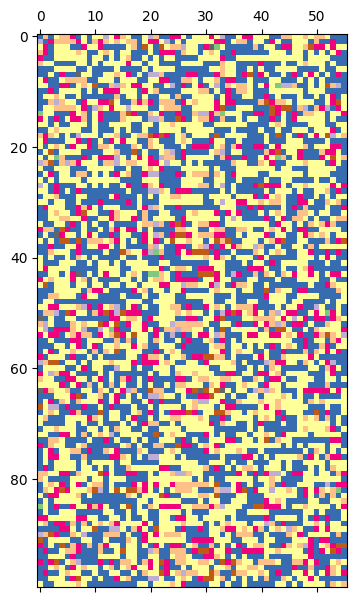

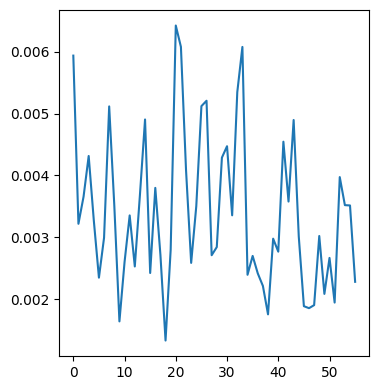

In [ ]:
weight_mat = clf_nn.coefs_[0].T
fig = plt.matshow(weight_mat, cmap=plt.cm.Accent)
plt.show()

weight_var = np.var(weight_mat, axis=0)
fig2 = plt.figure(figsize=(4, 4.5))
plt.plot(weight_var)
plt.show()

##### AdaBoost-based Feature Selection

Visualize feature importance

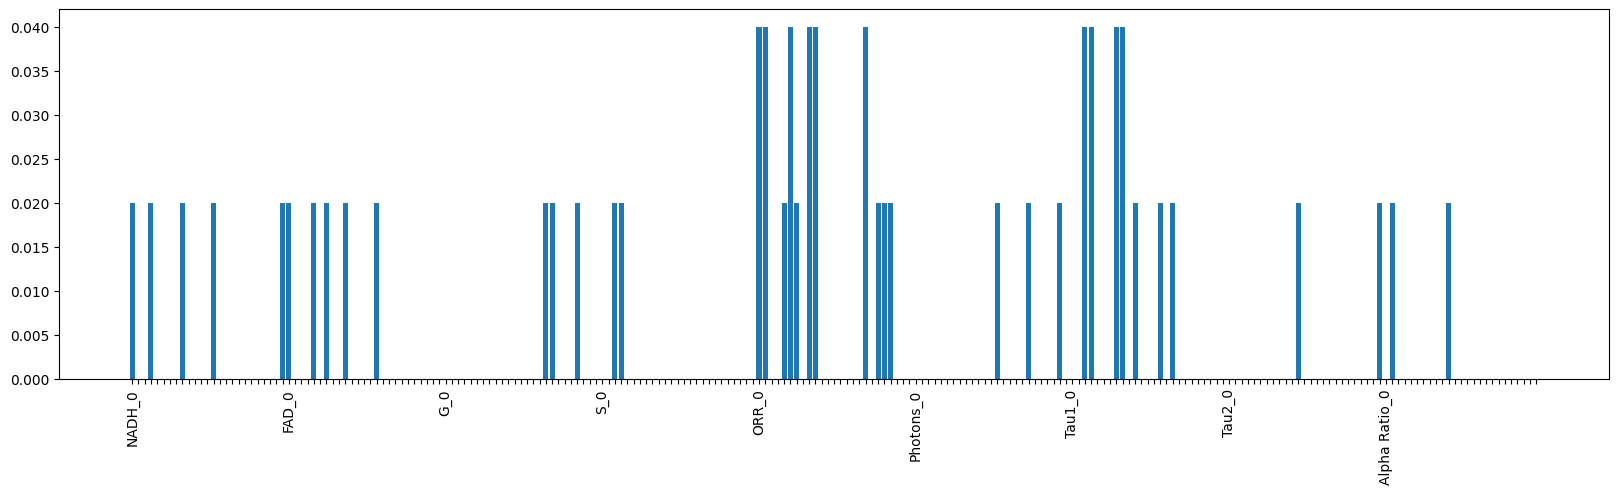

In [ ]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
p = ax.bar(feat_names, clf_ab.feature_importances_)
[l.set_visible(False) for (i,l) in enumerate(ax.get_xticklabels()) if i%25 !=0];
plt.xticks(rotation=90);

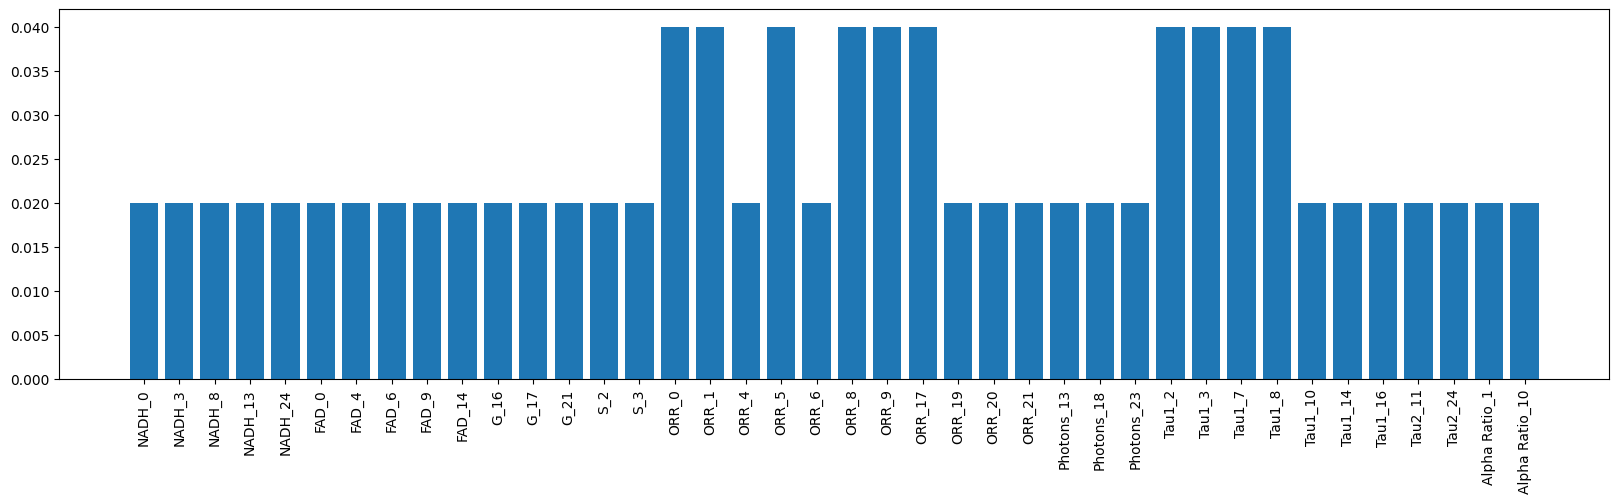

In [ ]:
selection = []
for f3 in clf_ab.feature_importances_:
  n0 = f3 > 0
  selection.append(n0)
sel_feats_imp = np.array([feat for feat, select in zip( clf_ab.feature_importances_, selection) if select])
sel_feats_nam = np.array([name for name, select in zip(feat_names, selection) if select])

fig, ax = plt.subplots()
fig.set_figwidth(20)
p = ax.bar(sel_feats_nam, sel_feats_imp)
plt.xticks(rotation=90);

Data has 225 features.


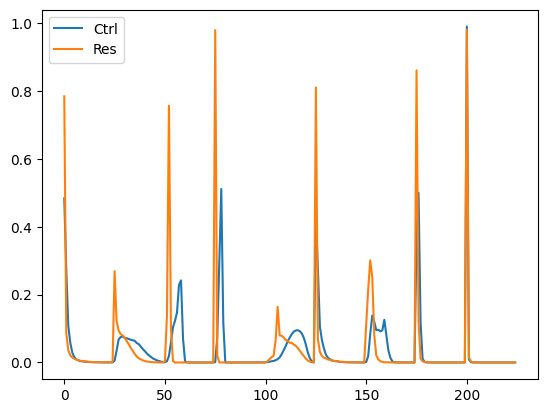

In [ ]:
# Plot one random sample from each class
idx1 = np.random.randint(0, len(X))
idx2 = np.random.randint(0, len(X))
p = plt.plot(X[idx1], label='Res' if y[idx1] == 1 else 'Ctrl')
while y[idx2] == y[idx1]:
  idx2 = np.random.randint(0, len(X))
p = plt.plot(X[idx2], label='Res' if y[idx2] == 1 else 'Ctrl')
leg = plt.legend()

print(f'Data has {np.shape(X)[1]} features.')

Data has 40 features.


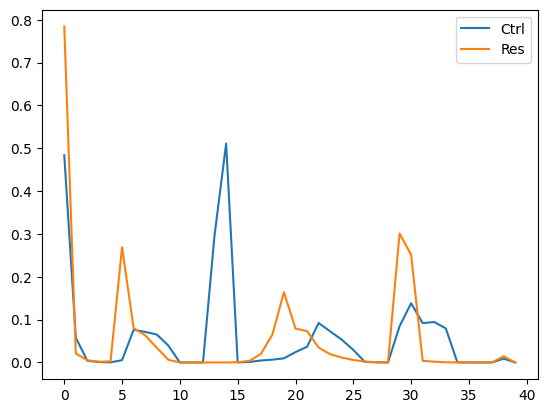

In [ ]:
X_sel = np.array([feat for feat, select in zip(X.T, selection) if select])
X_sel = X_sel.T

# Plot the same two samples but now the whittled data
p2 = plt.plot(X_sel[idx1], label='Res' if y[idx1] == 1 else 'Ctrl')
p2 = plt.plot(X_sel[idx2], label='Res' if y[idx2] == 1 else 'Ctrl')
leg = plt.legend()

print(f'Data has {np.shape(X_sel)[1]} features.')

In [ ]:
# Scale data (standardization)
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_sel)

# Shuffle final dataset and split
X_scale, y_shuff = shuffle(X_scale, y)
X_train, X_test, y_train, y_test = train_test_split(
    X_scale, y_shuff, test_size=0.4, random_state=42
)

# Fit classifiers
# MLP
clf_ab = AdaBoostClassifier()
clf_ab.fit(X_train, y_train)
score["AdaBoost with selection"] = clf_ab.score(X_test, y_test)
gc.collect()

58507

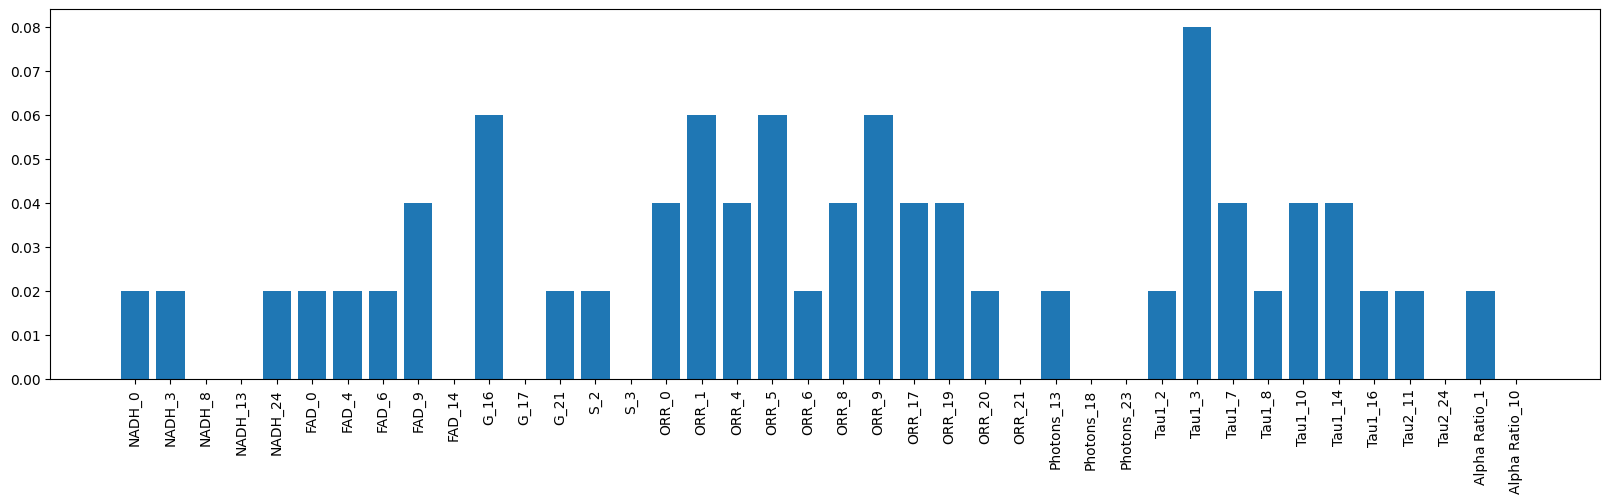

In [ ]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
p = ax.bar(sel_feats_nam, clf_ab.feature_importances_)
plt.xticks(rotation=90);

##### Results

In [ ]:
# Show all results
for key, val in score.items():
  print(f'{key}: {val*100:.2f}%')

Neural Net: 78.57%
AdaBoost: 77.88%
Neural Net with Selection: 78.34%
AdaBoost with selection: 75.58%


### One-by-one hard-code hyper feature selection
Testing each hyper-feature (imaging modality) alone with best performing classifiers (Gauss Proc, MLP, and AdaBoost).

In [ ]:
print(f'Testing indiviudal hyper-feature: {modes}')

Testing indiviudal hyper-feature: ['NADH', 'FAD', 'G', 'S', 'ORR', 'Photons', 'Tau1', 'Tau2', 'Alpha Ratio']


In [ ]:
names = [
    "Gaussian Process",
    "Neural Net",
    "AdaBoost",
]

classifiers = [
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
]

In [ ]:
results = {}
for mode in modes:
  # Reload XT dataset
  times = ['1hpt', '24hpt', '48hpt']
  treatment = ['XT']
  sen_img_set, res_img_set, sen_dist_set, res_dist_set = {}, {}, {}, {},
  keys =[]

  for tx in treatment:
    for t in times:
      key = (tx + '_' + t)
      dir_ext = os.sep + tx + os.sep + t
      try:
        sen_img_set[key] = UMSCCDataset('Stacks/22B' + dir_ext, mode, augment = True)
        res_img_set[key] = UMSCCDataset('Stacks/47' + dir_ext, mode, augment = True)
        sen_dist_set[key] = DistData(sen_img_set[key].images, bins=25)
        res_dist_set[key] = DistData(res_img_set[key].images, bins=25)
        sen_dist_set[key].normalize()
        res_dist_set[key].normalize()
        keys.append(key)
      except Exception as e:
        print(f'Skipping {key}: {e}')

  X = np.array([]).reshape(0, np.shape(sen_dist_set[key].dists)[1])
  y = np.array([])
  for key in keys:
    # Define sensitive and resistant data sets for pair
    X_sen = sen_dist_set[key].dists
    y_sen = sen_img_set[key].labels
    X_res = res_dist_set[key].dists
    y_res = res_img_set[key].labels

    # Combine
    X = np.concatenate((X, X_sen, X_res))
    y = np.concatenate((y, y_sen, y_res))

  # Shuffle final dataset and split
  X, y = shuffle(X, y)
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.4, random_state=42
  )

# Fit and test
  score = {}
  for name, clf in zip(names, classifiers):
      pipe = make_pipeline(StandardScaler(), clf)
      pipe.fit(X_train, y_train)
      score[name] = pipe.score(X_test, y_test)
      gc.collect()
  results[mode] = score

C:\Users\jdivers\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\jdivers\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\jdivers\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  w

In [ ]:
label, height = [], []

for hf, res in results.items():
  print(hf)
  for clfr, scr in res.items():
    print(f'{clfr}: {scr*100:.2f}%')
    label.append(hf + ' ' + clfr)
    height.append(scr)
  print()

NADH
Gaussian Process: 48.62%
Neural Net: 48.62%
AdaBoost: 48.62%

FAD
Gaussian Process: 50.00%
Neural Net: 50.00%
AdaBoost: 50.00%

G
Gaussian Process: 53.00%
Neural Net: 54.61%
AdaBoost: 54.15%

S
Gaussian Process: 50.00%
Neural Net: 55.30%
AdaBoost: 53.23%

ORR
Gaussian Process: 48.62%
Neural Net: 48.62%
AdaBoost: 48.62%

Photons
Gaussian Process: 50.92%
Neural Net: 51.84%
AdaBoost: 52.53%

Tau1
Gaussian Process: 49.31%
Neural Net: 49.31%
AdaBoost: 49.31%

Tau2
Gaussian Process: 50.46%
Neural Net: 50.46%
AdaBoost: 50.46%

Alpha Ratio
Gaussian Process: 50.23%
Neural Net: 49.77%
AdaBoost: 50.23%



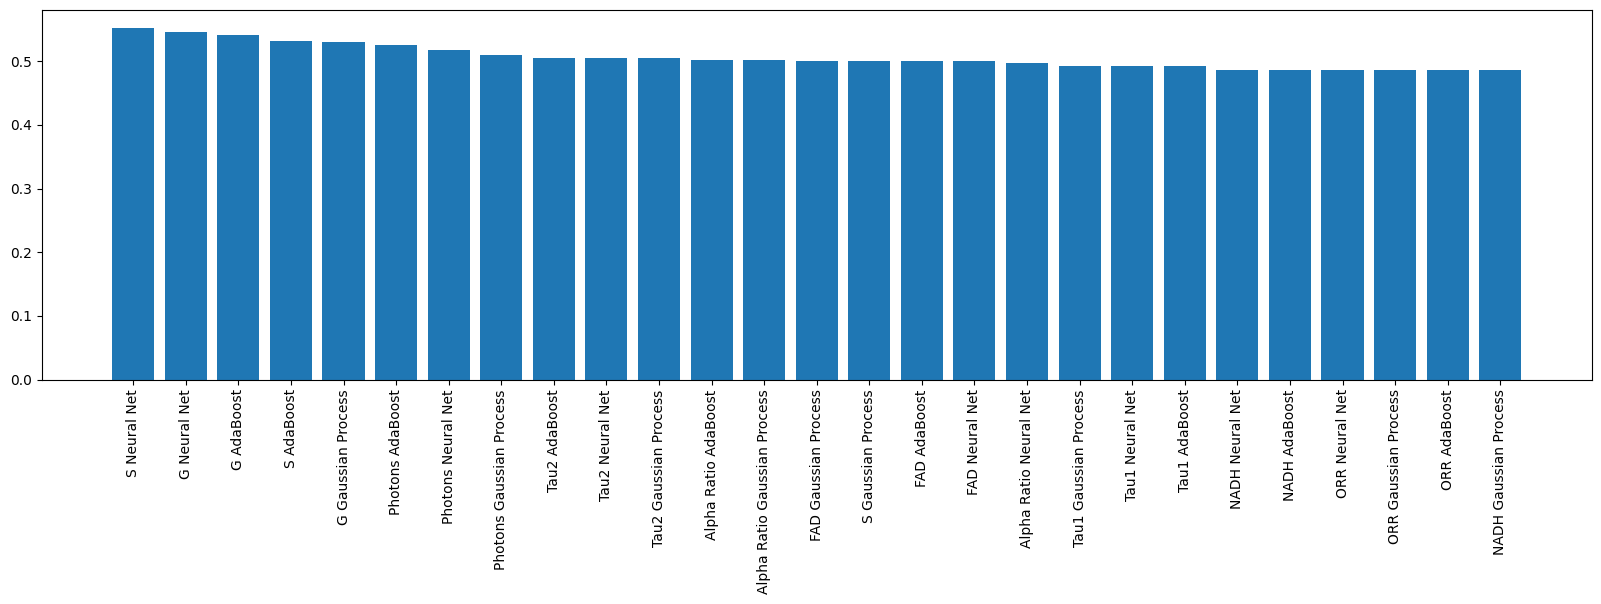

In [ ]:
rnk = np.argsort(height)
fig, ax = plt.subplots()
fig.set_figwidth(20)
p = ax.bar(np.array(label)[rnk[::-1]], np.array(height)[rnk[::-1]])
plt.xticks(rotation=90);

###### Using top 3 hyper features

In [ ]:
modes = ['G', 'Photons', 'S']
# Reload XT dataset
times = ['1hpt', '24hpt', '48hpt']
treatment = ['XT']
sen_img_set, res_img_set, sen_dist_set, res_dist_set = {}, {}, {}, {},
keys =[]

for tx in treatment:
  for t in times:
    key = (tx + '_' + t)
    dir_ext = os.sep + tx + os.sep + t
    try:
      sen_img_set[key] = UMSCCDataset('Stacks/22B' + dir_ext, modes, augment = True)
      res_img_set[key] = UMSCCDataset('Stacks/47' + dir_ext, modes, augment = True)
      sen_dist_set[key] = DistData(sen_img_set[key].images, bins=25)
      res_dist_set[key] = DistData(res_img_set[key].images, bins=25)
      sen_dist_set[key].normalize()
      res_dist_set[key].normalize()
      keys.append(key)
    except Exception as e:
      print(f'Skipping {key}: {e}')

X = np.array([]).reshape(0, np.shape(sen_dist_set[key].dists)[1])
y = np.array([])
for key in keys:
  # Define sensitive and resistant data sets for pair
  X_sen = sen_dist_set[key].dists
  y_sen = sen_img_set[key].labels
  X_res = res_dist_set[key].dists
  y_res = res_img_set[key].labels

  # Combine
  X = np.concatenate((X, X_sen, X_res))
  y = np.concatenate((y, y_sen, y_res))

# Shuffle final dataset and split
X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Fit and test
score = {}
for name, clf in zip(names, classifiers):
    pipe = make_pipeline(StandardScaler(), clf)
    pipe.fit(X_train, y_train)
    score[name] = pipe.score(X_test, y_test)
    gc.collect()

In [ ]:
for clfr, scr in score.items():
  print(f'{clfr}: {scr*100:.2f}%')

Gaussian Process: 54.38%
Neural Net: 58.29%
AdaBoost: 54.38%


###### Using best lifetime + best intensity
Best lifetime-based features is top 3 overall and, conveniently, the non-fit features, and best intensity-based features is all the intensity-based features.

In [ ]:
modes = ['G', 'S', 'ORR', 'Photons', 'NADH', 'FAD']
# Reload XT dataset
times = ['1hpt', '24hpt', '48hpt']
treatment = ['XT']
sen_img_set, res_img_set, sen_dist_set, res_dist_set = {}, {}, {}, {},
keys =[]

for tx in treatment:
  for t in times:
    key = (tx + '_' + t)
    dir_ext = os.sep + tx + os.sep + t
    try:
      sen_img_set[key] = UMSCCDataset('Stacks/22B' + dir_ext, modes, augment = True)
      res_img_set[key] = UMSCCDataset('Stacks/47' + dir_ext, modes, augment = True)
      sen_dist_set[key] = DistData(sen_img_set[key].images, bins=25)
      res_dist_set[key] = DistData(res_img_set[key].images, bins=25)
      sen_dist_set[key].normalize()
      res_dist_set[key].normalize()
      keys.append(key)
    except Exception as e:
      print(f'Skipping {key}: {e}')

X = np.array([]).reshape(0, np.shape(sen_dist_set[key].dists)[1])
y = np.array([])
for key in keys:
  # Define sensitive and resistant data sets for pair
  X_sen = sen_dist_set[key].dists
  y_sen = sen_img_set[key].labels
  X_res = res_dist_set[key].dists
  y_res = res_img_set[key].labels

  # Combine
  X = np.concatenate((X, X_sen, X_res))
  y = np.concatenate((y, y_sen, y_res))

# Shuffle final dataset and split
X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Fit and test
score = {}
for name, clf in zip(names, classifiers):
    pipe = make_pipeline(StandardScaler(), clf)
    pipe.fit(X_train, y_train)
    score[name] = pipe.score(X_test, y_test)
    gc.collect()

In [ ]:
for clfr, scr in score.items():
  print(f'{clfr}: {scr*100:.2f}%')

Gaussian Process: 76.04%
Neural Net: 79.26%
AdaBoost: 74.65%
